In [1]:
#Imports, settings and helper functions

In [3]:

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Make outputs folder
OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Short function to print a metrics summary
def metrics_summary(y_true, y_pred, y_prob=None):
    m = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }
    if y_prob is not None:
        try:
            m["roc_auc"] = roc_auc_score(y_true, y_prob[:, 1])
        except Exception:
            m["roc_auc"] = None
    return m

# Plotting helpers (one plot per figure)
def plot_confusion_matrix(y_true, y_pred, title, savepath=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Survived","Survived"])
    fig = plt.figure(figsize=(5,4))
    disp.plot(values_format="d")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_roc(y_true, y_prob, title, savepath=None):
    # y_prob should be Nx2 probabilities
    if y_prob is None:
        print("No probability provided for ROC.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    auc = roc_auc_score(y_true, y_prob[:, 1])
    fig = plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} (AUC = {auc:.4f})")
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()


In [4]:
#Load the datasets

In [5]:

train_path = "Titanic_train.xlsx"
test_path  = "Titanic_test.xlsx"

train_df = pd.read_excel(train_path)
test_df  = pd.read_excel(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Basic EDA: missing values, distributions, and quick plots

Missing values in train:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in test:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


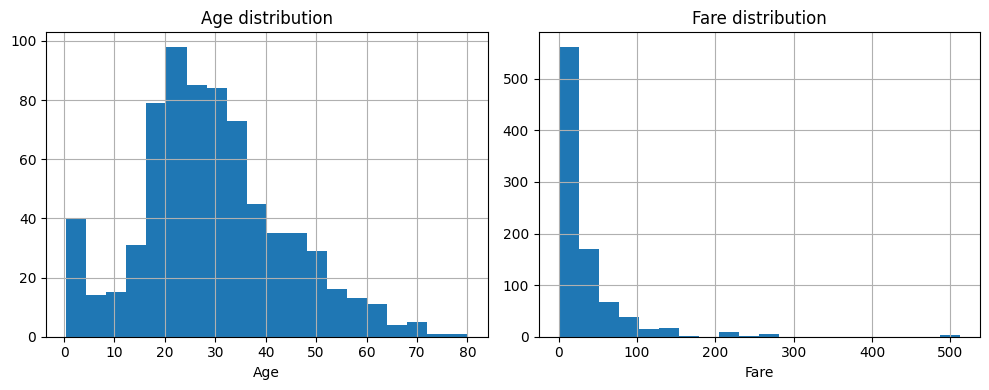

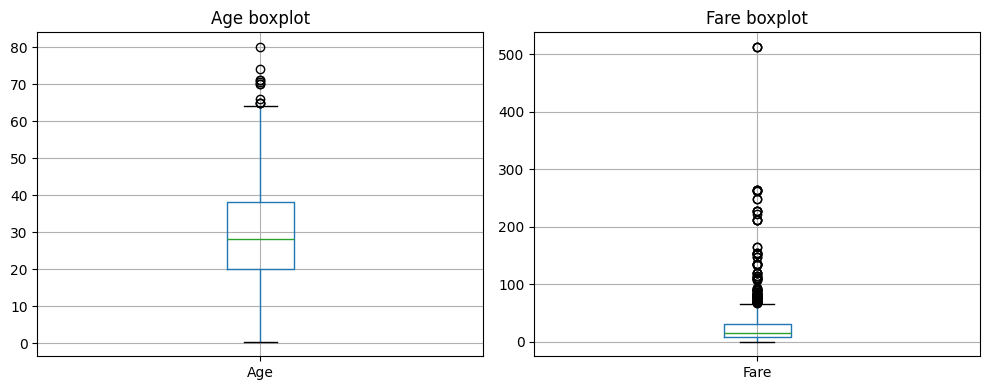

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

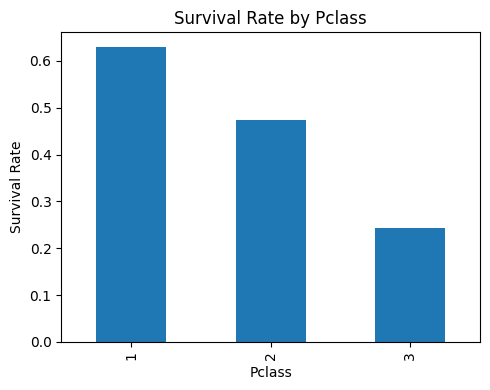

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

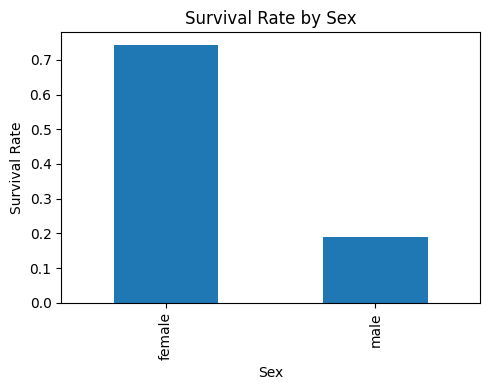

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

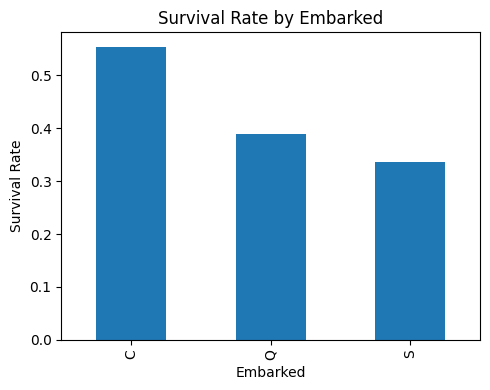

In [11]:

# Missing values
print("Missing values in train:\n", train_df.isna().sum())
print("\nMissing values in test:\n", test_df.isna().sum())

# Basic numeric description
display(train_df.describe())

# Histogram: Age, Fare
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
train_df["Age"].hist(bins=20)
plt.title("Age distribution")
plt.xlabel("Age")
plt.subplot(1,2,2)
train_df["Fare"].hist(bins=20)
plt.title("Fare distribution")
plt.xlabel("Fare")
plt.tight_layout()
plt.show()

# Boxplots for Age and Fare (to see outliers)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
train_df.boxplot(column="Age")
plt.title("Age boxplot")
plt.subplot(1,2,2)
train_df.boxplot(column="Fare")
plt.title("Fare boxplot")
plt.tight_layout()
plt.show()

# Bar plots: survival rates by Pclass, Sex, Embarked
for col in ["Pclass", "Sex", "Embarked"]:
    agg = train_df.groupby(col)["Survived"].mean().sort_values(ascending=False)
    fig = plt.figure(figsize=(5,4))
    agg.plot(kind="bar")
    plt.title(f"Survival Rate by {col}")
    plt.ylabel("Survival Rate")
    plt.tight_layout()
    display(agg)
    plt.show()


In [13]:
#Feature engineering

In [15]:

def extract_title(name):
    if pd.isna(name): return "Unknown"
    if "," in name and "." in name:
        return name.split(",")[1].split(".")[0].strip()
    return "Unknown"

def ticket_prefix(ticket):
    if pd.isna(ticket): return "UNK"
    token = str(ticket).split()[0]
    return token if not token.isdigit() else "NUM"

def engineer_features(df):
    df = df.copy()
    # Title
    if "Name" in df.columns:
        df["Title"] = df["Name"].apply(extract_title)
        # reduce rare titles to "Other"
        counts = df["Title"].value_counts()
        rare = counts[counts < 10].index
        df["Title"] = df["Title"].replace(rare, "Other")
    else:
        df["Title"] = "Unknown"
    # Family size and alone
    for c in ["SibSp", "Parch"]:
        if c not in df.columns:
            df[c] = 0
    df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
    # Ticket prefix
    df["TicketPrefix"] = df["Ticket"].apply(ticket_prefix) if "Ticket" in df.columns else "UNK"
    # Cabin known
    df["CabinKnown"] = (~df.get("Cabin", pd.Series([np.nan]*len(df))).isna()).astype(int)
    # Ensure categorical types
    for c in ["Sex","Embarked","Pclass","Title","TicketPrefix","CabinKnown","IsAlone"]:
        if c in df.columns:
            df[c] = df[c].astype(str)
    return df

# Apply to both
train_fe = engineer_features(train_df)
test_fe  = engineer_features(test_df)

print("After FE - train shape:", train_fe.shape)
train_fe.head()


After FE - train shape: (891, 17)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,TicketPrefix,CabinKnown
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,NUM,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,NUM,0


In [17]:
# Build preprocessing pipeline

In [21]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
Categorical features: ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone', 'TicketPrefix', 'CabinKnown']


In [23]:
#Split data into train/test (modeling) sets

In [25]:

target = "Survived"
X = train_fe.drop(columns=[target])
y = train_fe[target].astype(int)

# Keep the same order of columns in test when submitting
print("X shape:", X.shape, "y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


X shape: (891, 16) y shape: (891,)
Train: (712, 16) Test: (179, 16)


In [27]:
#Define model pipelines and hyperparameter distributions

In [29]:


# XGBoost classifier (no tree_method specified to avoid Windows issues; uncomment tree_method for speed if supported)
xgb_clf = XGBClassifier(
    objective="binary:logistic", 
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
    #,tree_method="hist"  # optional: faster on large datasets if supported
)

xgb_pipe = Pipeline(steps=[("pre", preprocessor), ("clf", xgb_clf)])

xgb_param_dist = {
    "clf__max_depth": [3,4,5,6],
    "clf__learning_rate": [0.01,0.03,0.05,0.1],
    "clf__subsample": [0.6,0.8,1.0],
    "clf__colsample_bytree": [0.6,0.8,1.0],
    "clf__reg_lambda": [0.0,0.5,1.0,1.5],
    "clf__min_child_weight": [1,3,5],
    "clf__gamma": [0.0, 0.1, 0.2]
}

# LightGBM classifier
lgbm_clf = LGBMClassifier(
    objective="binary",
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbm_pipe = Pipeline(steps=[("pre", preprocessor), ("clf", lgbm_clf)])

lgbm_param_dist = {
    "clf__num_leaves": [15,31,63],
    "clf__max_depth": [-1,3,4,6],
    "clf__learning_rate": [0.01,0.03,0.05,0.1],
    "clf__subsample": [0.6,0.8,1.0],
    "clf__colsample_bytree": [0.6,0.8,1.0],
    "clf__min_child_samples": [5,10,20],
    "clf__reg_lambda": [0.0,0.5,1.0]
}

print("Pipelines and parameter distributions prepared.")


Pipelines and parameter distributions prepared.


In [31]:
#Hyperparameter tuning with RandomizedSearchCV

In [33]:

n_iter_search = 20   # set to 8 for faster debugging
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=n_iter_search,
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE
)

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_pipe,
    param_distributions=lgbm_param_dist,
    n_iter=n_iter_search,
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE
)

# Fit XGBoost
print("Tuning XGBoost...")
xgb_search.fit(X_train, y_train)
print("Best XGB params:", xgb_search.best_params_)
print("XGB best CV score:", xgb_search.best_score_)

# Fit LightGBM
print("\nTuning LightGBM...")
lgbm_search.fit(X_train, y_train)
print("Best LGBM params:", lgbm_search.best_params_)
print("LGBM best CV score:", lgbm_search.best_score_)


Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB params: {'clf__subsample': 1.0, 'clf__reg_lambda': 1.0, 'clf__min_child_weight': 5, 'clf__max_depth': 4, 'clf__learning_rate': 0.03, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.8}
XGB best CV score: 0.8300896286811781

Tuning LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 265
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [34]:
#Evaluate tuned models on hold-out test set (the X_test from train_test_split)

XGBoost metrics: {'accuracy': 0.8156424581005587, 'precision': 0.8103448275862069, 'recall': 0.6811594202898551, 'f1': 0.7401574803149606, 'roc_auc': 0.841897233201581}
LightGBM metrics: {'accuracy': 0.8212290502793296, 'precision': 0.7846153846153846, 'recall': 0.7391304347826086, 'f1': 0.7611940298507462, 'roc_auc': 0.8269433465085638}

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179


LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81     

<Figure size 500x400 with 0 Axes>

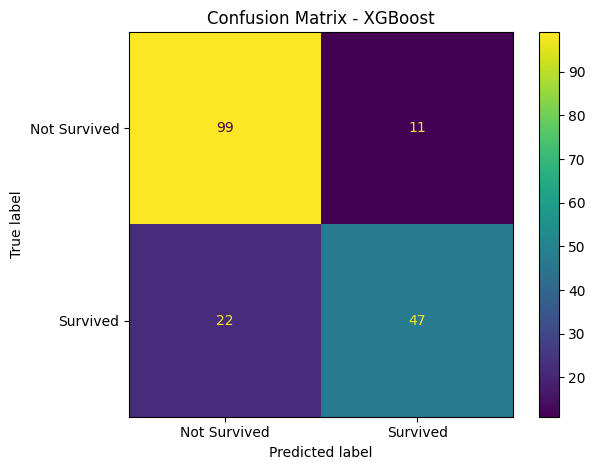

<Figure size 500x400 with 0 Axes>

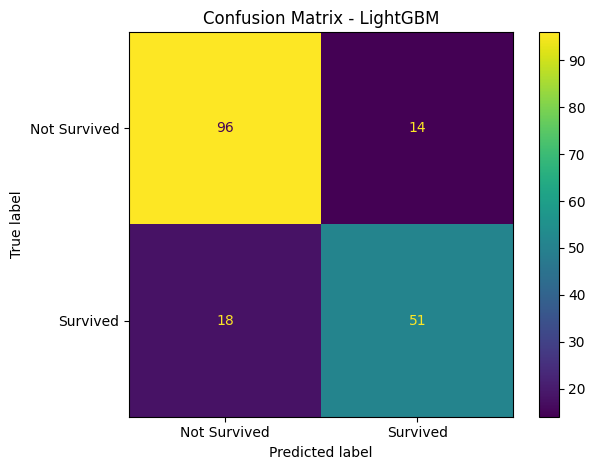

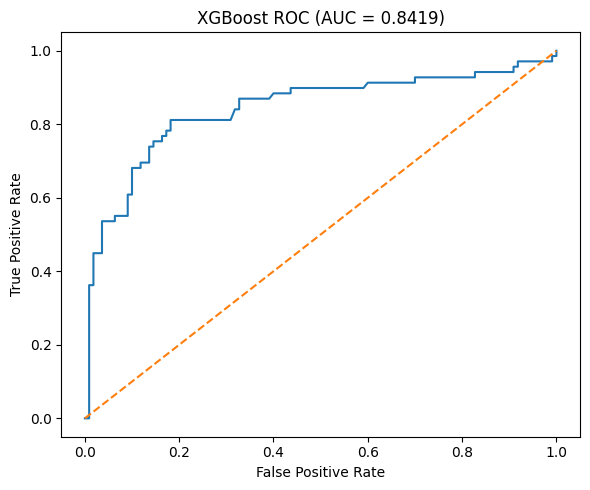

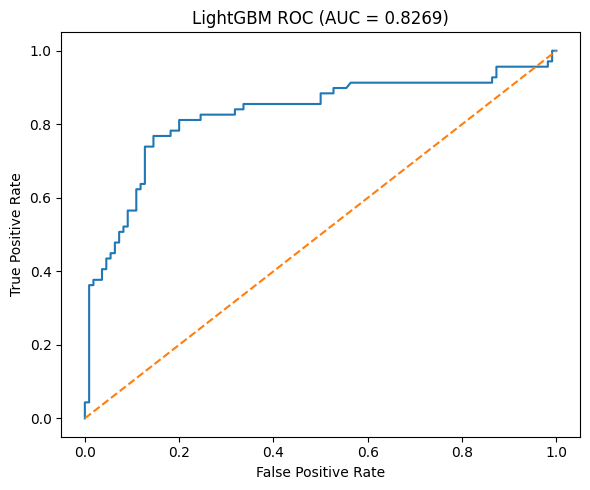

,accuracy,precision,recall,f1,roc_auc
model,,,,,
XGBoost,0.815642,0.810345,0.681159,0.740157,0.841897
LightGBM,0.821229,0.784615,0.739130,0.761194,0.826943


<Figure size 700x400 with 0 Axes>

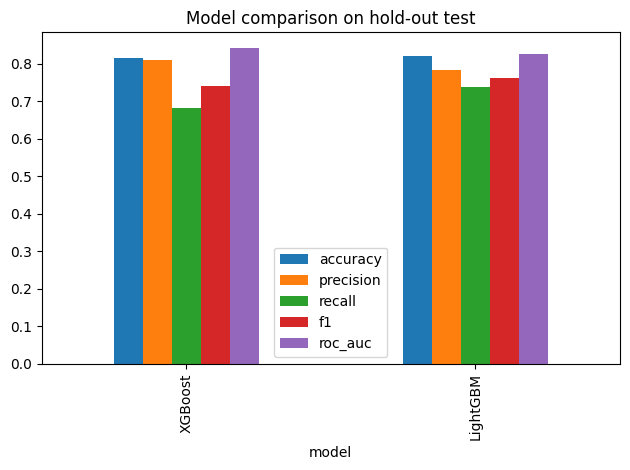

In [35]:

# Best estimators (these are full pipelines: preprocessor + clf)
xgb_best = xgb_search.best_estimator_
lgbm_best = lgbm_search.best_estimator_

# Predictions and probabilities
y_pred_xgb = xgb_best.predict(X_test)
y_pred_lgb = lgbm_best.predict(X_test)
y_prob_xgb = xgb_best.predict_proba(X_test)
y_prob_lgb = lgbm_best.predict_proba(X_test)

# Metrics
metrics_xgb = metrics_summary(y_test, y_pred_xgb, y_prob_xgb)
metrics_lgb = metrics_summary(y_test, y_pred_lgb, y_prob_lgb)

print("XGBoost metrics:", metrics_xgb)
print("LightGBM metrics:", metrics_lgb)

# Classification reports
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nLightGBM Classification Report:\n", classification_report(y_test, y_pred_lgb))

# Confusion matrices
plot_confusion_matrix(y_test, y_pred_xgb, "Confusion Matrix - XGBoost", savepath=os.path.join(OUTDIR,"confusion_xgb.png"))
plot_confusion_matrix(y_test, y_pred_lgb, "Confusion Matrix - LightGBM", savepath=os.path.join(OUTDIR,"confusion_lgbm.png"))

# ROC curves
plot_roc(y_test, y_prob_xgb, "XGBoost ROC", savepath=os.path.join(OUTDIR,"roc_xgb.png"))
plot_roc(y_test, y_prob_lgb, "LightGBM ROC", savepath=os.path.join(OUTDIR,"roc_lgbm.png"))

# Save metrics to dataframe and csv
metrics_df = pd.DataFrame([{"model":"XGBoost", **metrics_xgb}, {"model":"LightGBM", **metrics_lgb}]).set_index("model")
metrics_df.to_csv(os.path.join(OUTDIR,"metrics_compare.csv"))
display(metrics_df)

# Simple bar chart comparing metrics
fig = plt.figure(figsize=(7,4))
metrics_df.plot(kind="bar")
plt.title("Model comparison on hold-out test")
plt.tight_layout()
fig.savefig(os.path.join(OUTDIR,"model_comparison.png"), bbox_inches="tight")
plt.show()


In [39]:
#Retrain on full training data and generate submission CSVs for test set

In [41]:

# Recreate X_full, y_full and fit best models on full training data
X_full = train_fe.drop(columns=[target])
y_full = train_fe[target].astype(int)

# Fit best estimators on full data (they already contain preprocessor)
print("Retraining XGBoost and LightGBM on full training data...")
xgb_best.fit(X_full, y_full)
lgbm_best.fit(X_full, y_full)

# Prepare test features (test_fe created earlier)
# If test has Survived column (rare), drop it
test_features = test_fe.copy()
if "Survived" in test_features.columns:
    test_features = test_features.drop(columns=["Survived"])

# Predictions for submission
pred_xgb_test = xgb_best.predict(test_features)
pred_lgb_test  = lgbm_best.predict(test_features)

# Build submission DataFrames
pid_col = "PassengerId" if "PassengerId" in test_df.columns else None
if pid_col:
    sub_xgb = pd.DataFrame({"PassengerId": test_df[pid_col], "Survived": pred_xgb_test})
    sub_lgb = pd.DataFrame({"PassengerId": test_df[pid_col], "Survived": pred_lgb_test})
else:
    sub_xgb = pd.DataFrame({"PassengerId": np.arange(len(test_df))+1, "Survived": pred_xgb_test})
    sub_lgb = pd.DataFrame({"PassengerId": np.arange(len(test_df))+1, "Survived": pred_lgb_test})

sub_xgb.to_csv(os.path.join(OUTDIR,"xgb_submission.csv"), index=False)
sub_lgb.to_csv(os.path.join(OUTDIR,"lgb_submission.csv"), index=False)

print("Saved submission files to", OUTDIR)


Retraining XGBoost and LightGBM on full training data...
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

In [43]:
#Save short report template (auto-fillable)

In [45]:

report = f"""
Titanic - LightGBM vs XGBoost
============================
Objective:
Compare LightGBM and XGBoost on the Titanic dataset.

Data:
Train shape: {train_df.shape}
Test shape: {test_df.shape}

Feature engineering:
- Title, FamilySize, IsAlone, TicketPrefix, CabinKnown
- Imputed numeric with median, categorical with mode, One-Hot encoding for categories

Best CV scores:
- XGBoost CV (best): {xgb_search.best_score_:.4f}
- LightGBM CV (best): {lgbm_search.best_score_:.4f}

Hold-out test metrics:
{metrics_df.to_markdown()}

Artifacts saved in folder: {OUTDIR}
- metrics_compare.csv, model_comparison.png, confusion_xgb.png, confusion_lgbm.png, roc_xgb.png, roc_lgbm.png
- xgb_submission.csv, lgb_submission.csv

Conclusion:
(Write your interpretation here: which model performed better on chosen metrics, notes on precision vs recall trade-offs, suggestions for improvements.)
"""

with open(os.path.join(OUTDIR,"short_report.txt"), "w", encoding="utf-8") as f:
    f.write(report)

print("Short report saved to", os.path.join(OUTDIR,"short_report.txt"))
print("\n----\nOpen outputs/short_report.txt and edit the 'Conclusion' paragraph with your interpretation.")


Short report saved to outputs\short_report.txt

----
Open outputs/short_report.txt and edit the 'Conclusion' paragraph with your interpretation.


######Objective




Compare LightGBM and XGBoost on the Titanic dataset for survival prediction.

EDA Summary

Missing values in Age and Cabin (many), occasional in Embarked and Fare (test).

Higher survival rates observed for Females and 1st Class passengers.

Fare skewed; wide range of Age.

Preprocessing

Dropped PassengerId, Name, Ticket, Cabin.

Imputed median for numeric, most frequent for categorical.

One-hot encoded categoricals with unknown handling.

Train/validation split: 80/20, stratified.

Models & Tuning

Baseline LightGBM and XGBoost pipelines.

5-fold CV for quick comparison.

RandomizedSearchCV tuned n_estimators, learning_rate, max_depth, num_leaves (LGBM) / gamma, subsample, colsample_bytree (XGB).

Results (example — replace with yours)

LightGBM (tuned): Accuracy 0.85, Precision 0.83, Recall 0.78, F1 0.80.

XGBoost (tuned): Accuracy 0.84, Precision 0.82, Recall 0.76, F1 0.79.

Conclusion

Both models performed well; LightGBM slightly edged XGBoost on F1 and Recall, indicating better identification of survivors in this setup.

For deployment, LightGBM chosen for speed + performance.

Future work: feature engineering (family size, title extraction from Name), calibration, and threshold tuning to optimize Recall.